# import statements

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, GaussianNoise, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# load dataset

In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# eda

In [6]:
df.shape

(284807, 31)

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
df.isnull().values.any()

False

In [9]:
pd.value_counts(df['Class'], sort = True)

0    284315
1       492
Name: Class, dtype: int64

In [10]:
sns.set(style='whitegrid', palette='muted', font_scale=1.75)
rcParams['figure.figsize'] = 14, 8.7
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

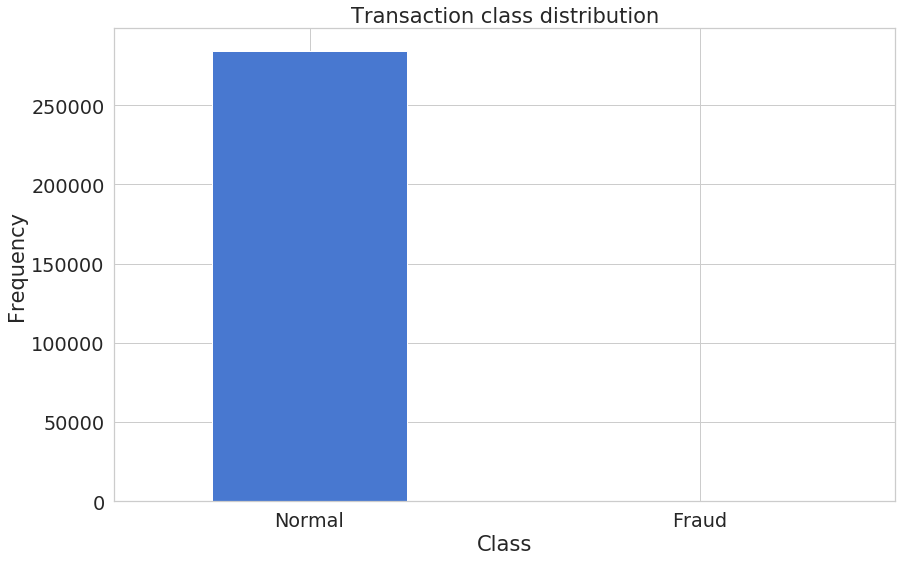

In [11]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [12]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [13]:
frauds.shape, normal.shape

((492, 31), (284315, 31))

In [14]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

# visual eda

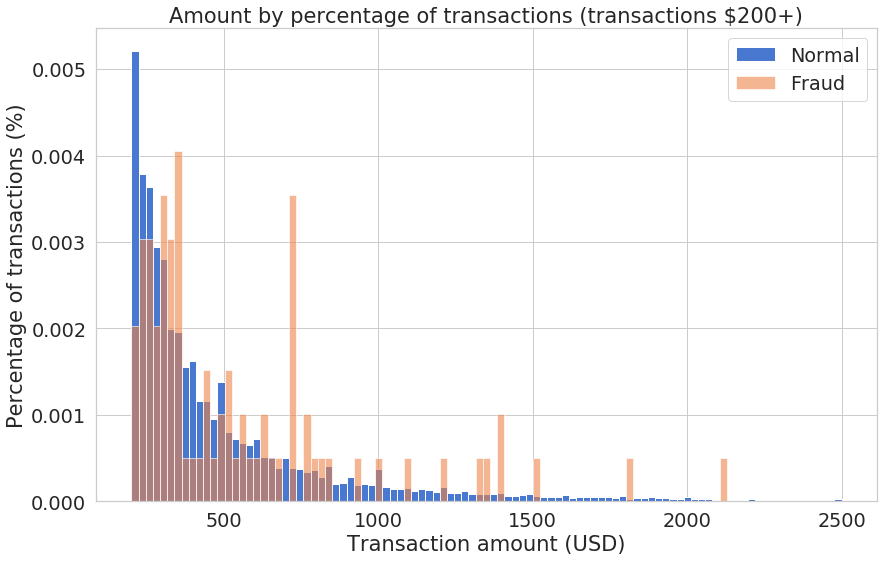

In [16]:
bins = np.linspace(200, 2500, 100)
plt.hist(normal.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(frauds.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

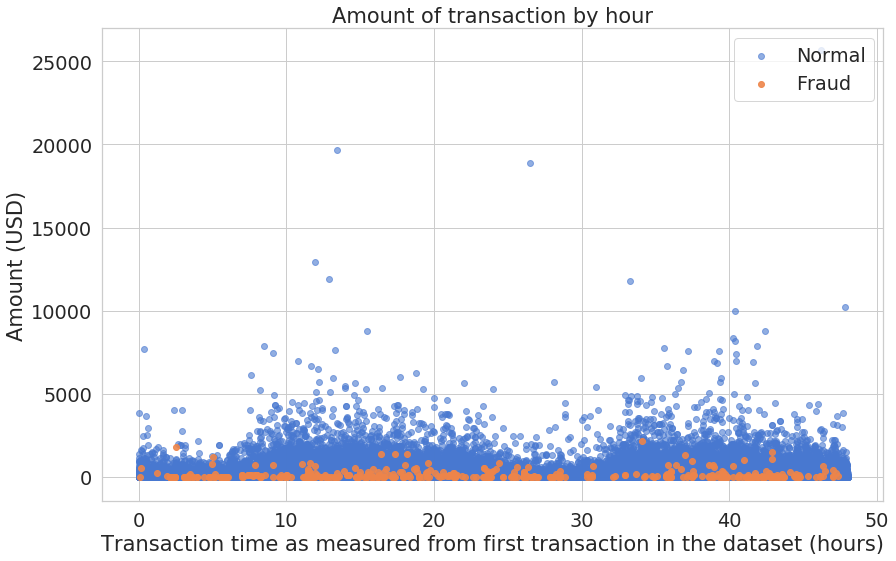

In [17]:
plt.scatter((normal.Time/(60*60)), normal.Amount, alpha=0.6, label='Normal')
plt.scatter((frauds.Time/(60*60)), frauds.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

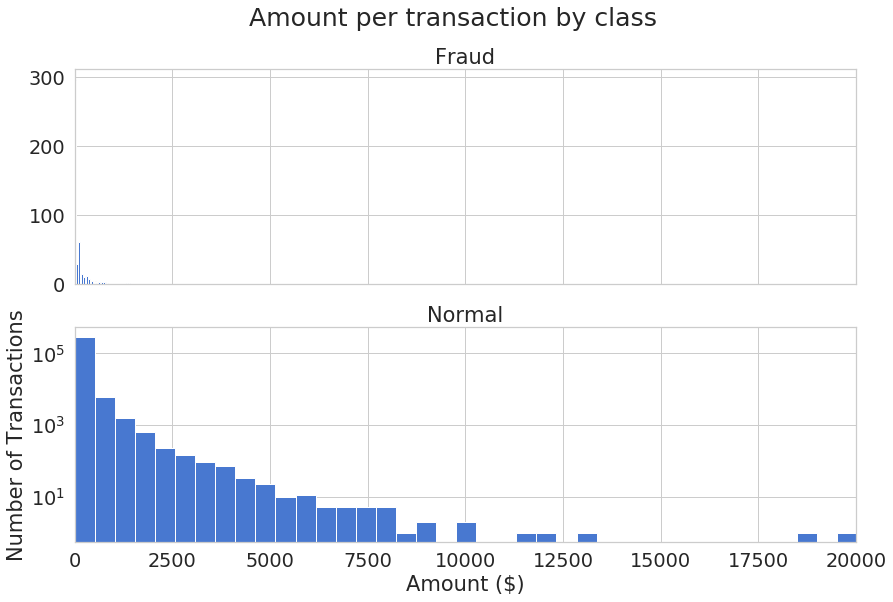

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

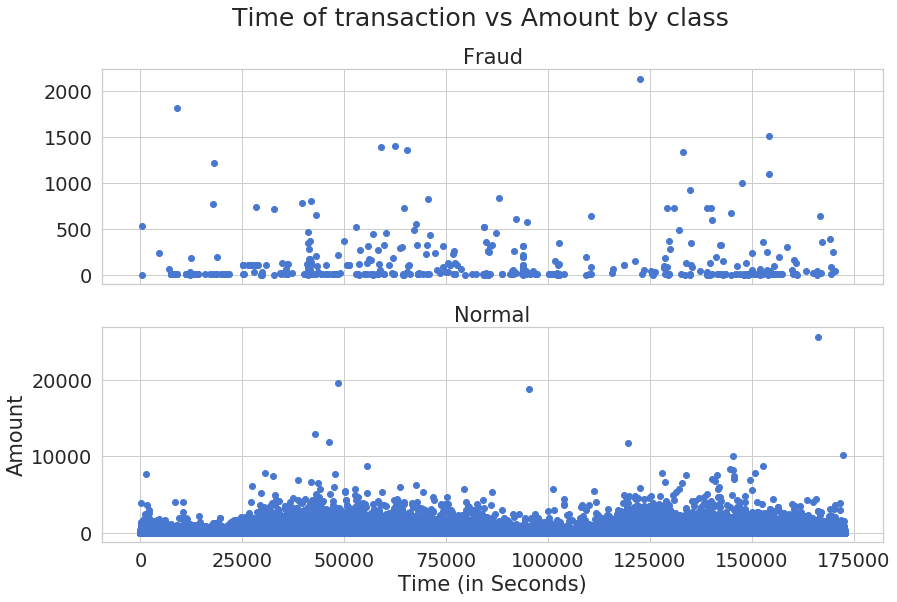

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# data preparation

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [22]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [23]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [24]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [25]:
X_train.shape

(227451, 30, 1)

In [26]:
X_test.shape

(56962, 30, 1)

# model structure

In [27]:
nb_epoch = 10
batch_size = 16
learning_rate = 10e-5

input_size = X_train.shape[1:]
input_data = Input(shape=(*input_size,), name='input')
x = GaussianNoise(stddev=0.1)(input_data)
x = Conv1D(32, 3, activation='relu', padding='same', activity_regularizer=regularizers.l1(learning_rate))(x)
x = MaxPooling1D(pool_size= 3)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size= 2)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

encoded = Dense(64, activation='relu')(x)

x = Dense(128, activation='relu')(encoded)
x = Dense(80, activation='relu')(x)
x = Reshape((5,16))(x)
x = Dropout(0.25)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(3)(x)
decoded = Conv1D(1, 3, activation='linear', padding='same')(x)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 1)             0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 16)             0         
__________

In [28]:
from time import *
t0=time()
autoencoder.compile(optimizer=Adam(lr=0.0001, beta_2=0.99), loss='mean_squared_error')

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    callbacks=[EarlyStopping(patience=10)]).history

print("training time:", round((time()-t0)/60, 3), "mins")

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 305s 1ms/step - loss: 0.7786 - val_loss: 0.6069
Epoch 2/10
227451/227451 [==============================] - 254s 1ms/step - loss: 0.6020 - val_loss: 0.4986
Epoch 3/10
227451/227451 [==============================] - 292s 1ms/step - loss: 0.5336 - val_loss: 0.4289
Epoch 4/10
227451/227451 [==============================] - 272s 1ms/step - loss: 0.4850 - val_loss: 0.3820
Epoch 5/10
227451/227451 [==============================] - 372s 2ms/step - loss: 0.4542 - val_loss: 0.3580
Epoch 6/10
227451/227451 [==============================] - 253s 1ms/step - loss: 0.4336 - val_loss: 0.3325
Epoch 7/10
227451/227451 [==============================] - 291s 1ms/step - loss: 0.4188 - val_loss: 0.3096
Epoch 8/10
227451/227451 [==============================] - 281s 1ms/step - loss: 0.3971 - val_loss: 0.3001
Epoch 9/10
227451/227451 [==============================] - 301s 1ms/step - loss: 0.3

# model evaluation

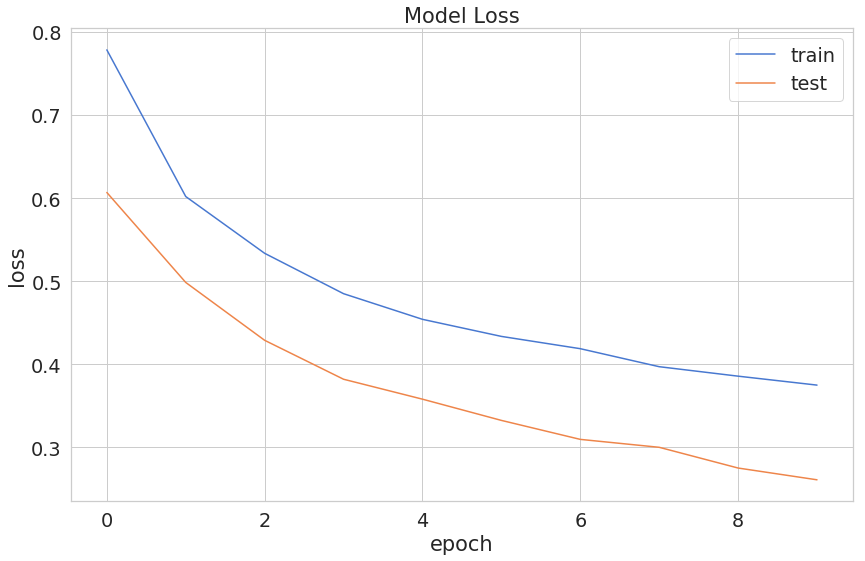

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [30]:
predictions = autoencoder.predict(X_test)

In [31]:
predictions.shape

(56962, 30, 1)

In [32]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
X_test.shape

(56962, 30)

In [33]:
predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
predictions.shape

(56962, 30)

In [34]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [35]:
mse

array([33.84461004,  0.30530028,  0.15620619, ...,  0.31542587,
        0.07289417,  0.62825707])

In [36]:
error_df.head()

,reconstruction_error,true_class
43428,33.844610,1
49906,0.305300,0
29474,0.156206,0
276481,0.148949,0
278846,0.060586,0


In [37]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.252910,0.001720
std,0.964432,0.041443
min,0.020710,0.000000
25%,0.097162,0.000000
50%,0.153694,0.000000
75%,0.254800,0.000000
max,74.481128,1.000000


In [38]:
error_df.sort_values(ascending=False, by = 'reconstruction_error').head(10)

,reconstruction_error,true_class
154587,74.481128,1
154371,66.579634,1
151006,56.091021,1
152223,47.305465,1
118764,45.506302,0
150654,37.544767,1
42635,36.291603,1
8615,35.892311,1
44270,35.791122,1
9252,34.930635,1


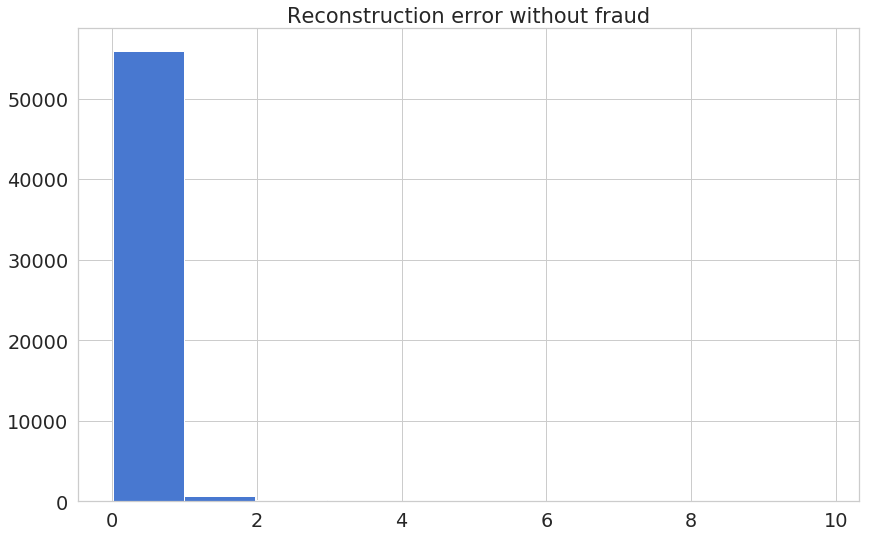

In [39]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.title('Reconstruction error without fraud')
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


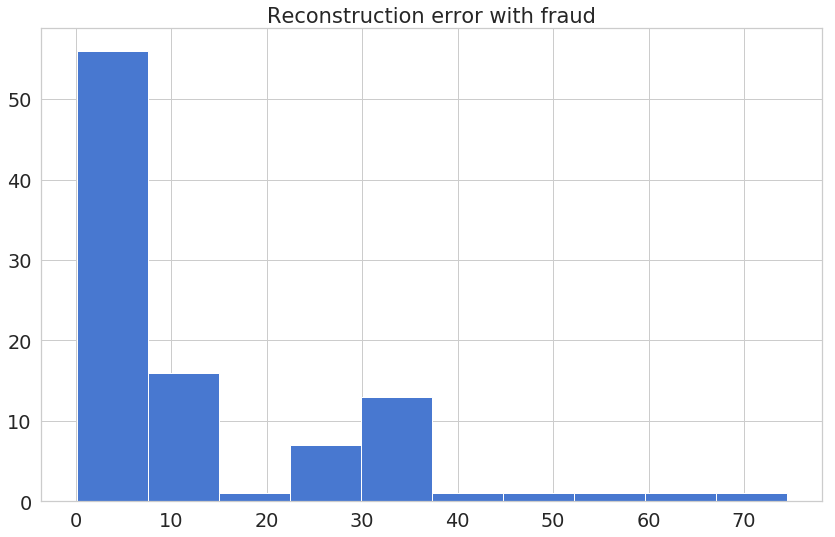

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Reconstruction error with fraud')
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [41]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

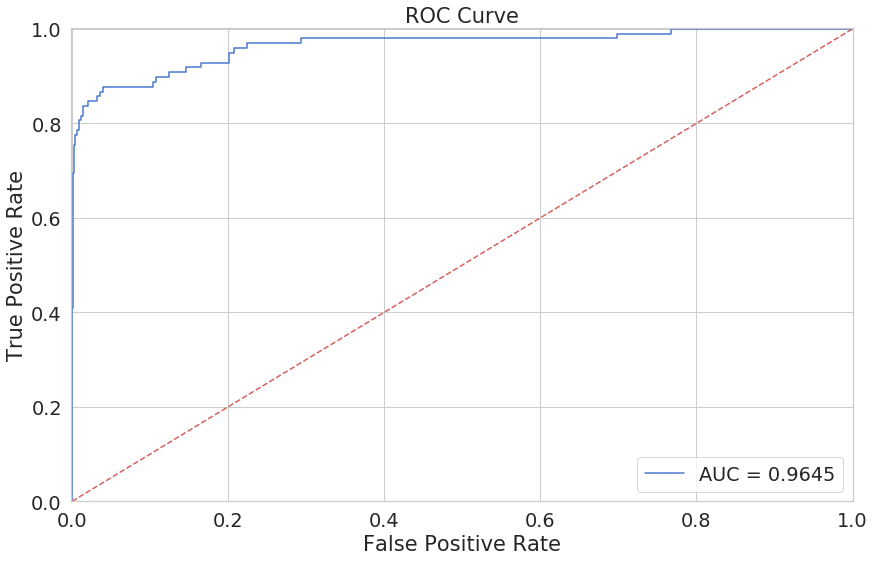

In [42]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

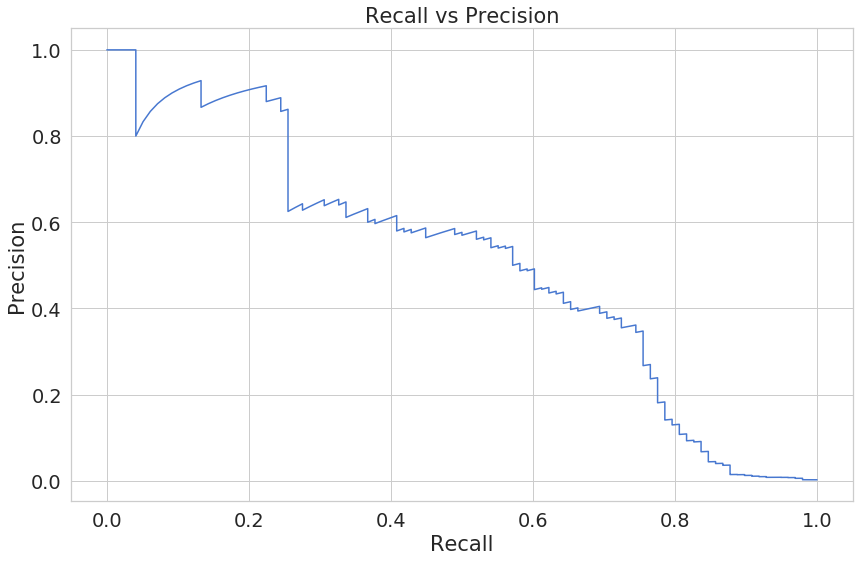

In [43]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

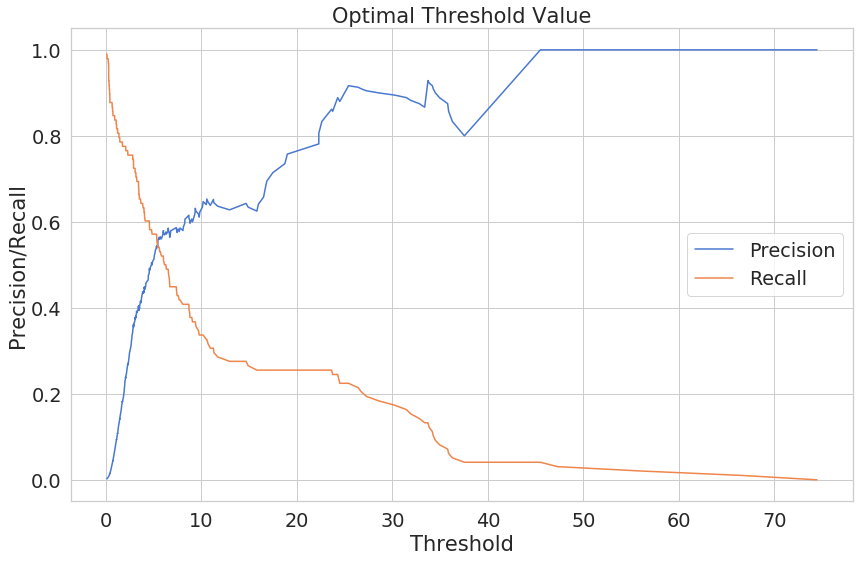

In [44]:
plt.plot(th, precision[1:], label="Precision")
plt.plot(th, recall[1:], label="Recall")
plt.title('Optimal Threshold Value')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [45]:
threshold = 6

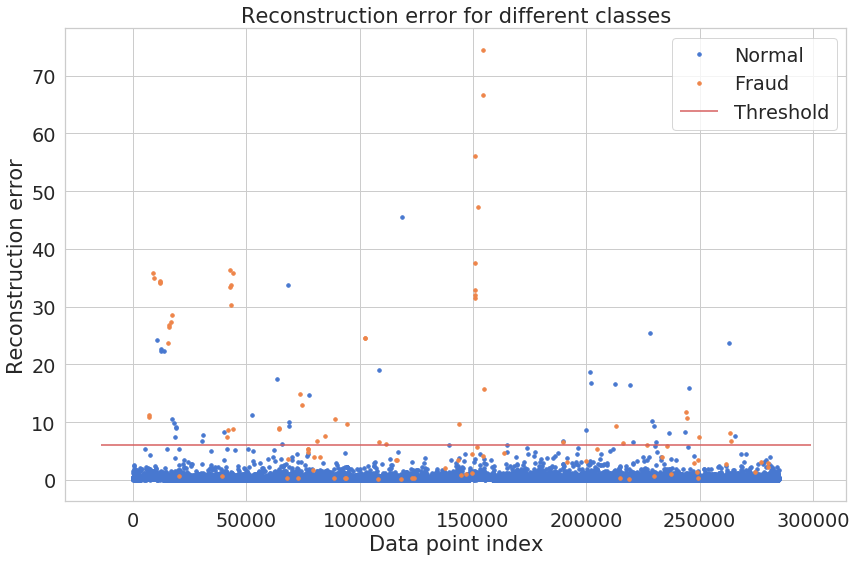

In [46]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

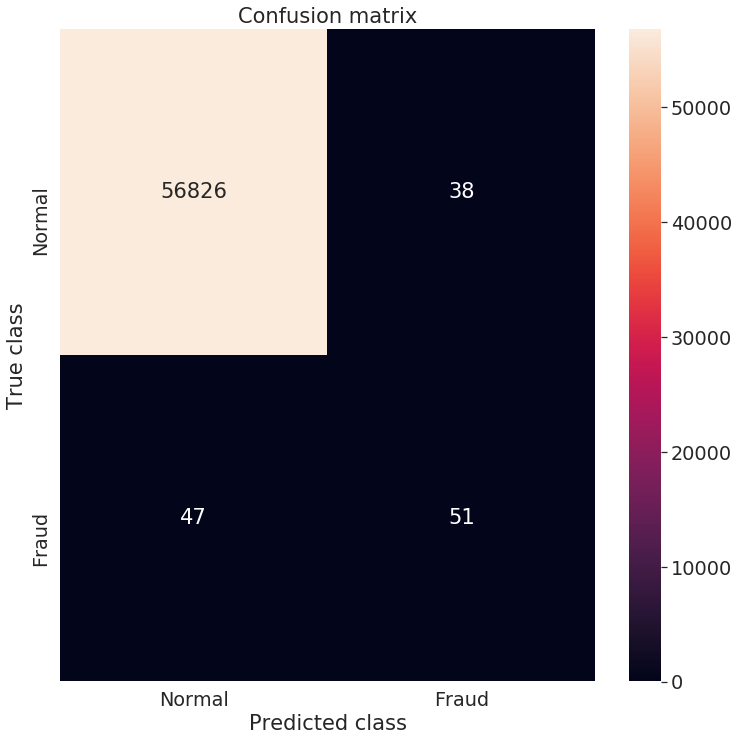

In [47]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [48]:
print('F1-score: {0}'.format(f1_score(y_test, y_pred)))

F1-score: 0.5454545454545454


In [49]:
from sklearn.metrics import classification_report, accuracy_score
print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.52      0.55        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.79      0.76      0.77     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score:  0.9985077771145676
